In [1]:
from transformers import pipeline
import numpy as np
import pandas as pd
import gzip
import fastparquet
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from transformers import AutoModel, AutoTokenizer


In [2]:
#read conceptnet
conceptnet = pd.read_parquet('conceptnet_small.parquet.gzip',columns=['uri','relation','start_node','end_node','info'])

#choose object for which to search relations
room =  'kitchen'
room = '/c/en/' + room

#choose whether the object will be the start or end node relation
node = 'end_node'

#get relations for specified objects and associated info for each relationship (make more specific to object)
object_relations = conceptnet[conceptnet[node] == room]

#create object list
objs = []

for i in range(object_relations.shape[0]):
    objs.append(object_relations['start_node'].iloc[i][6:])
    

In [3]:
#use second word in word pairing
objects = []

for i in range(len(objs)):
    tmp = str(objs[i]).split('_')
    objects.append(tmp[len(tmp)-1])

In [6]:
# load bert
unmasker = pipeline('fill-mask', model = 'bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [125]:
# get objects
all_objs = pd.read_excel('post_objects.xlsx')
landmarks = all_objs['landmark'].iloc[0:14]
objects = all_objs['target']

In [126]:
#tokenize objects for bert
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

landmark = []

for i in range(len(landmarks)):
    new = tokenizer.tokenize(landmarks[i])
    
    if len(new[0]) == len(landmarks[i]):
        landmark.append(new[0])
        
target = []

for i in range(len(objects)):
    new = tokenizer.tokenize(objects[i])
    
    if len(new[0]) == len(objects[i]):
        target.append(new[0])


In [127]:
# co-occurrence mat
cooccur = np.zeros((len(landmark),len(target)))

for i in range(len(landmark)):
    for j in range(len(target)):
        sentence = 'The [MASK] is on the ' + landmark[i]
        result = unmasker(sentence, targets = target[j])
        cooccur[i,j] = result[0].get("score")

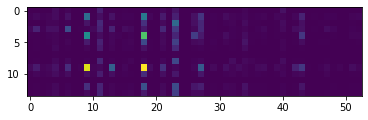

In [128]:
plt.imshow(cooccur)

In [133]:
pair = []
for i in range(len(target)):
    idx = np.flip(np.argsort(cooccur[:,i]))
    pair.append(landmark[idx[0]])

In [138]:
idx = np.flip(np.argsort(cooccur[:,26]))
landmark[idx[2]]

'counter'

In [134]:
temp = pd.DataFrame(target)
temp.insert(1,"landmark",pair)
temp

,0,landmark
0,basket,table
1,bowl,floor
2,can,table
3,candle,floor
4,case,table
5,catalog,shelf
6,chair,floor
7,cinnamon,counter
8,cloth,table
9,coffee,table
